In [1]:

import gpatlas
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Dataset
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pandas as pd
from pathlib import Path
from typing import cast
import h5py
import time as tm
from datetime import datetime

In [2]:

#variables
n_phen=2
n_loci = 200
n_alleles = 2
latent_space_g = 3000
EPS = 1e-15


batch_size = 1000
num_workers = 3

base_file_name = 'test_sim_WF_1kbt_100k_100sites_'



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

##########################################################################################

loaders = gpatlas.create_data_loaders(base_file_name, batch_size=128, num_workers=3, shuffle=True)

train_loader_geno = loaders['train_loader_geno']
test_loader_geno = loaders['test_loader_geno']

train_loader_pheno = loaders['train_loader_pheno']
test_loader_pheno = loaders['test_loader_pheno']

train_loader_gp = loaders['train_loader_gp']
test_loader_gp = loaders['test_loader_gp']

##########################################################################################
##########################################################################################

def kl_divergence_loss(model, prior_var=1.0):
    """KL divergence to standard normal prior N(0,1)"""
    kl_loss = 0
    for param in model.parameters():
        # Simplified KL for fixed variance posterior to N(0,1) prior
        kl_loss += 0.5 * torch.sum(param ** 2)
    return kl_loss


Using device: cuda


In [3]:

# Training loop with tunable regularization strength
def train_gplinear(model, train_loader, test_loader,
          kl_weight = 0.01,
          learning_rate=0.001,
          max_epochs=200,
          min_delta = 0.001,
          patience = 20,
          device=device):

    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    history = {
    'train_loss': [],
    'test_loss': [],
    'epochs_trained': 0
    }

    # Early stopping variables
    best_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    patience_counter = 0


    for epoch in range(max_epochs):
        model.train()
        train_loss = 0

        for i, (phens, gens) in enumerate(train_loader):
            # Convert data to tensors
            phens = phens.to(device)
            gens = gens[:, : n_loci * n_alleles]
            gens = gens.to(device)

            # Forward pass
            output = model(gens)

            mse_loss = F.l1_loss(output + EPS, phens + EPS)
            kl_loss = kl_divergence_loss(model)
            # Combined loss (equivalent to ridge regression with lambda = kl_weight)
            total_loss = mse_loss + kl_weight * kl_loss

            # Backward and optimize
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            train_loss += total_loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation
        if test_loader is not None:
            model.eval()
            test_loss = 0

            with torch.no_grad():
                for phens, gens in test_loader:
                    phens = phens.to(device)
                    gens = gens[:, : n_loci * n_alleles]
                    gens = gens.to(device)
                    output = model(gens)
                    #evaluate on ordinary MSE loss
                    mse_loss = F.l1_loss(output + EPS, phens + EPS)
                    test_loss += mse_loss.item()

            avg_test_loss = test_loss / len(test_loader)
            history['test_loss'].append(avg_test_loss)

            print(f'Epoch: {epoch+1}/{max_epochs}, Train Loss: {avg_train_loss:.6f}, '
                  f'Test Loss: {avg_test_loss:.6f}')

            # Update learning rate
            scheduler.step(avg_test_loss)

            # Check for improvement
            if avg_test_loss < (best_loss - min_delta):
                best_loss = avg_test_loss
                best_epoch = epoch
                patience_counter = 0
                # Save best model state
                best_model_state = {k: v.cpu().detach().clone() for k, v in model.state_dict().items()}
                print(f"New best model at epoch {epoch+1} with test loss: {best_loss:.6f}")
            else:
                patience_counter += 1
                print(f"No improvement for {patience_counter} epochs (best: {best_loss:.6f})")

            # Early stopping check
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Record how many epochs were actually used
    history['epochs_trained'] = epoch + 1

    # Restore best model
    if best_model_state is not None:
        print(f"Restoring best model from epoch {best_epoch+1}")
        model.load_state_dict(best_model_state)

    return model, best_loss, history


In [4]:

def train_gpcombi(model, train_loader, test_loader=None,
                         linear_model=None,
                         n_loci=None,
                         n_alleles=2,
                         max_epochs=100,  # Set a generous upper limit
                         patience=10,      # Number of epochs to wait for improvement
                         min_delta=0.001, # Minimum change to count as improvement
                         learning_rate=0.001, weight_decay=1e-5, device=device):
    """
    Train model with early stopping to prevent overtraining
    """
    # Move model to device
    model = model.to(device)

    # Initialize optimizer with proper weight decay
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    history = {
        'train_loss': [],
        'test_loss': [],
        'epochs_trained': 0
    }

    # Early stopping variables
    best_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    patience_counter = 0

    # Training loop
    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss = 0

        for i, (phens, gens) in enumerate(train_loader):

            phens = phens.to(device)
            gens = gens[:, : n_loci * n_alleles]
            gens = gens.to(device)

            phens_add = linear_model(gens)

            # Forward pass
            optimizer.zero_grad()
            output = model(gens)

            # focal loss
            g_p_recon_loss = F.l1_loss(output + EPS, phens - (phens_add + EPS))

            # Backward and optimize
            g_p_recon_loss.backward()
            optimizer.step()

            train_loss += g_p_recon_loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation
        if test_loader is not None:
            model.eval()
            test_loss = 0

            with torch.no_grad():
                for phens, gens in test_loader:
                    phens = phens.to(device)
                    gens = gens[:, : n_loci * n_alleles]
                    gens = gens.to(device)

                    phens_add = linear_model(gens)

                    output = model(gens)
                    test_loss += F.l1_loss(phens_add + output + EPS, phens)

            avg_test_loss = test_loss / len(test_loader)
            history['test_loss'].append(avg_test_loss)

            print(f'Epoch: {epoch+1}/{max_epochs}, Train Loss: {avg_train_loss:.6f}, '
                  f'Test Loss: {avg_test_loss:.6f}')

            # Update learning rate
            scheduler.step(avg_test_loss)

            # Check for improvement
            if avg_test_loss < (best_loss - min_delta):
                best_loss = avg_test_loss
                best_epoch = epoch
                patience_counter = 0
                # Save best model state
                best_model_state = {k: v.cpu().detach().clone() for k, v in model.state_dict().items()}
                print(f"New best model at epoch {epoch+1} with test loss: {best_loss:.6f}")
            else:
                patience_counter += 1
                print(f"No improvement for {patience_counter} epochs (best: {best_loss:.6f})")

            # Early stopping check
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Record how many epochs were actually used
    history['epochs_trained'] = epoch + 1

    # Restore best model
    if best_model_state is not None:
        print(f"Restoring best model from epoch {best_epoch+1}")
        model.load_state_dict(best_model_state)

    return model, best_loss, history


In [5]:
linear_model = gpatlas.gplinear_kl(n_loci=n_loci,
                            n_phen=n_phen,
                            ).to(device)

linear_model, best_loss_gp, history = train_gplinear(model=linear_model,
                                            train_loader=train_loader_gp,
                                            test_loader=test_loader_gp,
                                            device=device)
linear_model.eval()

Epoch: 1/200, Train Loss: 1.956304, Test Loss: 1.932647
New best model at epoch 1 with test loss: 1.932647
Epoch: 2/200, Train Loss: 1.914926, Test Loss: 1.889988
New best model at epoch 2 with test loss: 1.889988
Epoch: 3/200, Train Loss: 1.878512, Test Loss: 1.856159
New best model at epoch 3 with test loss: 1.856159
Epoch: 4/200, Train Loss: 1.845662, Test Loss: 1.826105
New best model at epoch 4 with test loss: 1.826105
Epoch: 5/200, Train Loss: 1.814463, Test Loss: 1.795954
New best model at epoch 5 with test loss: 1.795954
Epoch: 6/200, Train Loss: 1.786458, Test Loss: 1.767544
New best model at epoch 6 with test loss: 1.767544
Epoch: 7/200, Train Loss: 1.760604, Test Loss: 1.741391
New best model at epoch 7 with test loss: 1.741391
Epoch: 8/200, Train Loss: 1.737815, Test Loss: 1.716548
New best model at epoch 8 with test loss: 1.716548
Epoch: 9/200, Train Loss: 1.717046, Test Loss: 1.695948
New best model at epoch 9 with test loss: 1.695948
Epoch: 10/200, Train Loss: 1.697564, 

gplinear_kl(
  (linear): Linear(in_features=200, out_features=2, bias=True)
)

In [6]:
true_phenotypes = []
linear_preds = []

with torch.no_grad():
    for phens, gens in test_loader_gp:
        gens = gens[:, : n_loci * n_alleles]
        phens = phens.to(device)
        gens = gens.to(device)

        # Get predictions
        linear_pred = linear_model(gens)
        true_phenotypes.append(phens.cpu().numpy())
        linear_preds.append(linear_pred.cpu().numpy())

Text(0.5, 1.0, '0 vs 1 Weights')

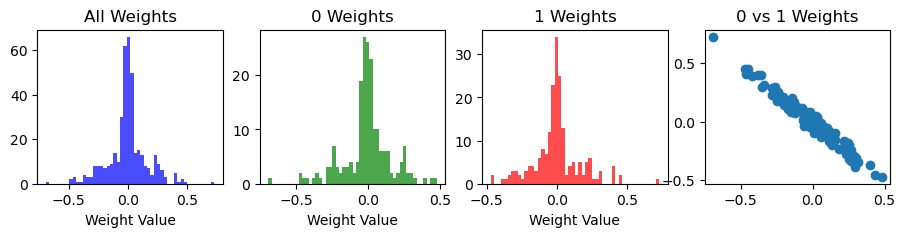

In [7]:
weights = linear_model.linear.weight.data.cpu()  # Shape: [n_phen, n_loci]


# Flatten the weights to 1D array for plotting
all_weights = weights.flatten()

# Get even and odd indexed weights
# Using numpy's advanced indexing
indices = np.arange(len(all_weights))
even_weights = all_weights[indices % 2 == 0]
odd_weights = all_weights[indices % 2 == 1]

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 4, figsize=(11, 2))

# Plot histogram of all weights
axs[0].hist(all_weights, bins=50, color='blue', alpha=0.7)
axs[0].set_title('All Weights')
axs[0].set_xlabel('Weight Value')

# Plot histogram of even-indexed weights
axs[1].hist(even_weights, bins=50, color='green', alpha=0.7)
axs[1].set_title('0 Weights')
axs[1].set_xlabel('Weight Value')

# Plot histogram of odd-indexed weights
axs[2].hist(odd_weights, bins=50, color='red', alpha=0.7)
axs[2].set_title('1 Weights')
axs[2].set_xlabel('Weight Value')

axs[3].scatter(even_weights,odd_weights)
axs[3].set_title('0 vs 1 Weights')


In [8]:
model = gpatlas.GP_net_combi(
    n_loci=n_loci,
    latent_space_g=latent_space_g,
    n_pheno=n_phen,
    linear_model=linear_model)

model, best_loss_gp, history = train_gpcombi(model=model,
                                        train_loader=train_loader_gp,
                                        test_loader=test_loader_gp,
                                        linear_model=linear_model,
                                        n_loci=n_loci,
                                        device=device)
model.eval()

Epoch: 1/100, Train Loss: 1.483829, Test Loss: 1.477670
New best model at epoch 1 with test loss: 1.477670
Epoch: 2/100, Train Loss: 1.404722, Test Loss: 1.443431
New best model at epoch 2 with test loss: 1.443431
Epoch: 3/100, Train Loss: 1.392956, Test Loss: 1.427498
New best model at epoch 3 with test loss: 1.427498
Epoch: 4/100, Train Loss: 1.385469, Test Loss: 1.436910
No improvement for 1 epochs (best: 1.427498)
Epoch: 5/100, Train Loss: 1.378314, Test Loss: 1.430776
No improvement for 2 epochs (best: 1.427498)
Epoch: 6/100, Train Loss: 1.369968, Test Loss: 1.518845
No improvement for 3 epochs (best: 1.427498)
Epoch: 7/100, Train Loss: 1.361729, Test Loss: 1.531271
No improvement for 4 epochs (best: 1.427498)
Epoch: 8/100, Train Loss: 1.336023, Test Loss: 1.443377
No improvement for 5 epochs (best: 1.427498)
Epoch: 9/100, Train Loss: 1.319163, Test Loss: 1.463561
No improvement for 6 epochs (best: 1.427498)
Epoch: 10/100, Train Loss: 1.300995, Test Loss: 1.555346
No improvement f

GP_net_combi(
  (linear_model): gplinear_kl(
    (linear): Linear(in_features=200, out_features=2, bias=True)
  )
  (gpnet): Sequential(
    (0): Linear(in_features=202, out_features=3000, bias=True)
    (1): BatchNorm1d(3000, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Linear(in_features=3000, out_features=3000, bias=True)
    (4): BatchNorm1d(3000, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=3000, out_features=2, bias=True)
    (7): BatchNorm1d(2, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  )
)

In [9]:

residual_preds = []

with torch.no_grad():
    for phens, gens in test_loader_gp:
        gens = gens[:, : n_loci * n_alleles]
        phens = phens.to(device)
        gens = gens.to(device)

        # Get predictions
        resid_pred = model(gens)
        residual_preds.append(resid_pred.cpu().numpy())

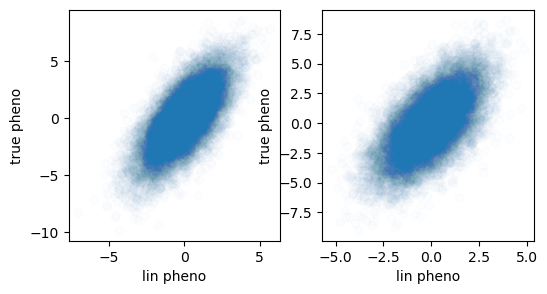

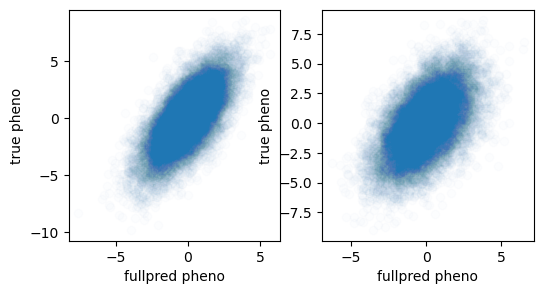

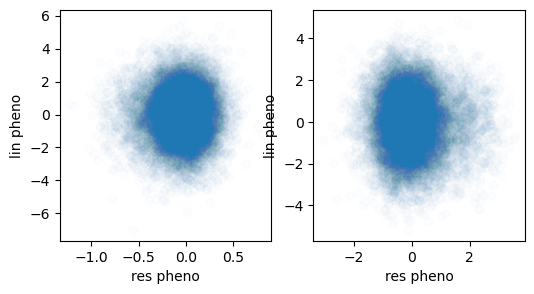

In [14]:
residual_preds_all = np.vstack(residual_preds)
truepheno_preds_all = np.vstack(true_phenotypes)
linear_preds_all = np.vstack(linear_preds)

fig, axes = plt.subplots(1, n_phen, figsize=(n_phen * 3, 3))

for i, ax in enumerate(axes):
    # Extract predictions for this phenotype
    linpreds = linear_preds_all[:, i]
    true_pheno = truepheno_preds_all[:, i]

    # Plot histogram
    ax.scatter(linpreds, true_pheno, alpha = 0.01)
    ax.set_xlabel('lin pheno')
    ax.set_ylabel('true pheno')

fig, axes = plt.subplots(1, n_phen, figsize=(n_phen * 3, 3))

for i, ax in enumerate(axes):
    # Extract predictions for this phenotype
    respreds = residual_preds_all[:, i]
    true_pheno = truepheno_preds_all[:, i]
    fullpreds = residual_preds_all[:, i] + linear_preds_all[:, i]

    # Plot histogram
    ax.scatter(fullpreds, true_pheno, alpha = 0.01)
    ax.set_xlabel('fullpred pheno')
    ax.set_ylabel('true pheno')


fig, axes = plt.subplots(1, n_phen, figsize=(n_phen * 3, 3))

for i, ax in enumerate(axes):
    # Extract predictions for this phenotype
    respreds = residual_preds_all[:, i]
    linpreds = linear_preds_all[:, i]

    # Plot histogram
    ax.scatter(respreds, linpreds, alpha = 0.01)
    ax.set_xlabel('res pheno')
    ax.set_ylabel('lin pheno')

In [18]:
#residual_preds_all


for i, ax in enumerate(axes):
    # Extract predictions for this phenotype
    linpreds = linear_preds_all[:, i]
    fullpreds = residual_preds_all[:, i] + linear_preds_all[:, i]
    true_pheno = truepheno_preds_all[:, i]


    print(pearsonr(linpreds,true_pheno))
    print(pearsonr(fullpreds,true_pheno))


PearsonRResult(statistic=0.6967866843005817, pvalue=0.0)
PearsonRResult(statistic=0.6896490728609912, pvalue=0.0)
PearsonRResult(statistic=0.6329437542538741, pvalue=0.0)
PearsonRResult(statistic=0.5406609982874127, pvalue=0.0)
